# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization, OceanographicUtilities

In [3]:
%cuda_context_handler gpu_ctx

## Finest vs Coarsest bathymetry information

In [4]:
nf160_url = "/sintef/data/NorFjords160/A10/norfjords_160m_his.nc4_2019071601-2019071700"

x0, x1, y0, y1 = 100, 1600, 125, 1125
nf160_data_args = NetCDFInitialization.getInitialConditions(nf160_url, x0, x1, y0, y1, download_data=False, norkyst_data=False)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


The Hm is one ring of cells smaller than eta,hu,hv


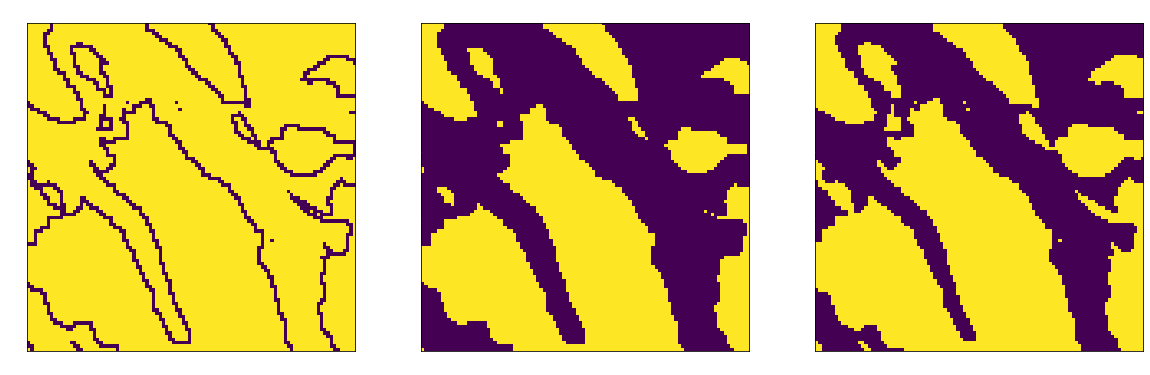

In [32]:
from gpuocean.SWEsimulators import CDKLM16
sim160 = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, **NetCDFInitialization.removeMetadata(nf160_data_args))

fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow( ( (sim160.bathymetry.Bm.data.get() == 1e20) == sim160.gpu_data.h0.mask)[150:250,50:150] )

axs[1].imshow( (sim160.bathymetry.Bm.data.get() == 1e20)[150:250,50:150] )
axs[1].set_title("Bm land")

axs[2].imshow( (sim160.gpu_data.h0.mask)[150:250,50:150] )
axs[2].set_title("eta land")

print("The Hm is one ring of cells smaller than eta,hu,hv")

In [8]:
from netCDF4 import Dataset
nc = Dataset(nf160_url)
land_value = 5.0
Hm_orig_data = nc["h"][y0-1:y1+1, x0-1:x1+1]
Hm_orig_mask = (Hm_orig_data == land_value)
Hm_orig = np.ma.array(Hm_orig_data, mask=Hm_orig_mask)

In [9]:
Hm_orig.shape

(1002, 1502)

In [10]:
data_args = NetCDFInitialization.rescaleInitialConditions(nf160_data_args, 1/5)
data_args["eta0"].shape

(200, 300)

In [11]:
## Alternative initial condtions: 
# First rescale midpoints and then to intersections

import copy

eta_coarse_data0 = OceanographicUtilities.rescaleMidpoints(nc["zeta"][0,y0-5:y1+5, x0-5:x1+5], 302, 202)[2]
eta_coarse_mask0 = copy.copy(eta_coarse_data0.mask)

Hm_coarse_data0 = OceanographicUtilities.rescaleMidpoints(nc["h"][y0-5:y1+5, x0-5:x1+5], 302, 202)[2]
Hm_coarse0 = np.ma.array(Hm_coarse_data0, mask=eta_coarse_mask0)

Hi_coarse0 = OceanographicUtilities.midpointsToIntersections(Hm_coarse0)[0]

In [12]:
## Alternative initial condtions:
# Use block reduce

# conda install -c conda-forge scikit-image
from skimage.measure import block_reduce

# eta_orig = nc["zeta"][0][y0-5:y1+5, x0-5:x1+5]
# eta_coarse_data = block_reduce(eta_orig.filled(0), block_size=(5,5), func=np.average)

# CHOSE A MASK REDUCTION STRATEGY
eta_coarse_mask1 = block_reduce(nc["zeta"][0][y0-5:y1+5, x0-5:x1+5].mask, block_size=(5,5), func=np.any)
eta_coarse_mask1 = block_reduce(nc["zeta"][0][y0-5:y1+5, x0-5:x1+5].mask, block_size=(5,5), func=np.all)

Hm_coarse_data1 = block_reduce(nc["h"][y0-5:y1+5, x0-5:x1+5], block_size=(5,5), func=np.average)
# Hm_coarse_data1 = OceanographicUtilities.rescaleMidpoints(nc["h"][y0-5:y1+5, x0-5:x1+5], 302, 202)[2]
Hm_coarse1 = np.ma.array(Hm_coarse_data1, mask=eta_coarse_mask1)

Hi_coarse1 = OceanographicUtilities.midpointsToIntersections(Hm_coarse1)[0]

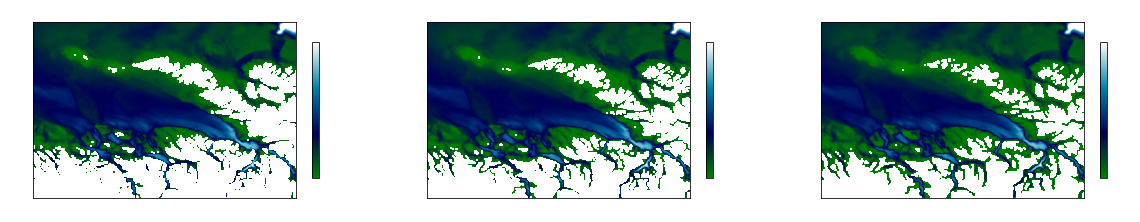

In [13]:
fig, axs = plt.subplots(1,3, figsize=(20,10))

im = axs[0].imshow(data_args["H"], vmax=750, cmap="ocean")
axs[0].set_title("1. Intersection, 2. Rescale")
plt.colorbar(im, ax=axs[0], shrink=0.25)

im = axs[1].imshow(Hi_coarse0, vmax=750, cmap="ocean")
axs[1].set_title("1. Rescale, 2. Intersection")
plt.colorbar(im, ax=axs[1], shrink=0.25)

im = axs[2].imshow(Hi_coarse1, vmax=750, cmap="ocean")
axs[2].set_title("1. Block Redcution, 2. Intersection")
plt.colorbar(im, ax=axs[2], shrink=0.25)

Idea: 
Use block reduction to closest integer and only rescale a bit in the end!

## Multi resolution simulation

In [14]:
from gpuocean.SWEsimulators import CDKLM16

In [15]:
sim = CDKLM16.CDKLM16(gpu_ctx, dt=0.0, **NetCDFInitialization.removeMetadata(data_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [16]:
loc = [[50, 50], [150,200]]
scale = 1.0

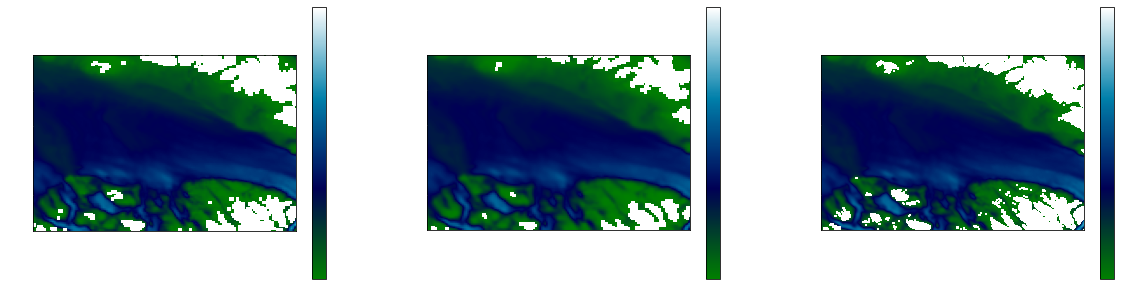

In [17]:
Hi = sim.bathymetry.download(sim.gpu_stream)[0]
Hm = sim.bathymetry.download(sim.gpu_stream)[1]

Hi_loc = Hi[loc[0][0]+2: loc[1][0]+3, loc[0][1]+2: loc[1][1]+3]
Hm_loc = Hm[loc[0][0]+2: loc[1][0]+2, loc[0][1]+2: loc[1][1]+2]

fig, axs = plt.subplots(1,3, figsize=(20,10))
im = axs[0].imshow(Hi_loc, vmax=750, cmap="ocean")
axs[0].set_title("Bi coarse")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(Hm_loc, vmax=750, cmap="ocean")
axs[1].set_title("Bm coarse")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(Hm_orig[1+5*(loc[0][0]+3): 1+5*(loc[1][0]+3), 1+5*(loc[0][1]+3): 1+5*(loc[1][1]+3)], vmax=750, cmap="ocean")
axs[2].set_title("Hm orig")
plt.colorbar(im, ax=axs[2], shrink=0.5)

#### Interpolation: First interpolate Midpoints and then go to intersections

In [18]:
from scipy import interpolate 

In [19]:
Hm_orig.shape

(1002, 1502)

In [20]:
x0 = np.linspace(0.5*nf160_data_args["dx"], (Hm_orig.shape[1]-0.5)*nf160_data_args["dx"], Hm_orig.shape[1])
y0 = np.linspace(0.5*nf160_data_args["dy"], (Hm_orig.shape[0]-0.5)*nf160_data_args["dy"], Hm_orig.shape[0])

interp = interpolate.interp2d(x0, y0, Hm_orig, kind="linear")

In [21]:
ny_loc, nx_loc = np.int32(scale*(np.array(loc[1])-np.array(loc[0])))
dx_loc, dy_loc = sim.dx/scale, sim.dy/scale

In [22]:
global_tex_x0 = (loc[0][1]+2)/(sim.nx+4)
global_tex_x1 = (loc[1][1]+2)/(sim.nx+4)
global_tex_x  = global_tex_x1 - global_tex_x0
global_tex_x0 = global_tex_x0 - 2.0/nx_loc*global_tex_x
global_tex_x1 = global_tex_x1 + 2.0/nx_loc*global_tex_x

global_tex_y0 = (loc[0][0]+2)/(sim.ny+4)
global_tex_y1 = (loc[1][0]+2)/(sim.ny+4)
global_tex_y  = global_tex_y1 - global_tex_y0
global_tex_y0 = global_tex_y0 - 2.0/ny_loc*global_tex_y
global_tex_y1 = global_tex_y1 + 2.0/ny_loc*global_tex_y

global_local_area = [ [ global_tex_y0, global_tex_x0 ], [ global_tex_y1, global_tex_x1 ] ]

In [23]:
# offset 1 for halo in Hm_orig
x1 = np.linspace((1.0+global_local_area[0][1]*(Hm_orig.shape[1]-2))*nf160_data_args["dx"]-0.5*dx_loc, (1.0+global_local_area[1][1]*(Hm_orig.shape[1]-2))*nf160_data_args["dx"]+0.5*dx_loc, nx_loc+6)
y1 = np.linspace((1.0+global_local_area[0][0]*(Hm_orig.shape[0]-2))*nf160_data_args["dy"]-0.5*dx_loc, (1.0+global_local_area[1][0]*(Hm_orig.shape[0]-2))*nf160_data_args["dy"]+0.5*dy_loc, ny_loc+6)
# with ghost cells and 1-cell halo

In [24]:
Hm_loc_refined_data = interp(x1, y1)
Hm_loc_refined_mask = (Hm_loc_refined_data<=5.1)

Hm_loc_refined = np.ma.array(Hm_loc_refined_data, mask=Hm_loc_refined_mask)

In [25]:
# METHOD OF CHOICE!!!
Hi_loc_refined = OceanographicUtilities.midpointsToIntersections(Hm_loc_refined)[0]

In [26]:
Hi_loc.shape

(101, 151)

#### Result

In [27]:
from gpuocean.utils.Common import Bathymetry, BoundaryConditions

bc = BoundaryConditions(3,3,3,3)

bathymetry = Bathymetry(gpu_ctx, sim.gpu_stream, scale*150, scale*100, 2, 2, Hi_loc_refined, bc)

Bi = bathymetry.download(sim.gpu_stream)[0]
Bm = bathymetry.download(sim.gpu_stream)[1]

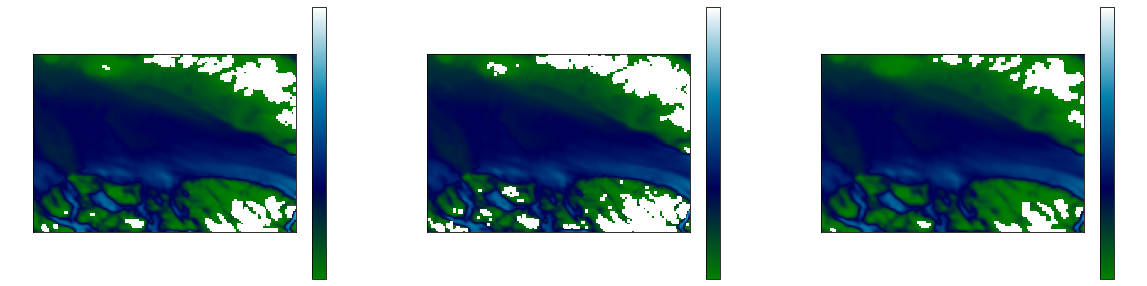

In [28]:
fig, axs = plt.subplots(1,3, figsize=(20,10))

im = axs[0].imshow(Hi_loc_refined, vmax=750, cmap="ocean")
axs[0].set_title("Bi refined")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(Hm_loc_refined, vmax=750, cmap="ocean")
axs[1].set_title("Hm refined")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(Bm, vmax=750, cmap="ocean")
axs[2].set_title("Bm refined")
plt.colorbar(im, ax=axs[2], shrink=0.5)

## Influence on the fields

...